In [1]:
import torch
import torch.optim as optim
import numpy as np
from NGCF import NGCF
from utility.helper import *
from utility.load_data import *
import multiprocessing
import heapq
import utility.metrics as metrics

import warnings
warnings.filterwarnings('ignore')
from time import time
import easydict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
args = easydict.EasyDict({
    'dataset': 'evdriver',
    'regs' : '[1e-5]',
    'embed_size': 64,
    'layer_size': '[64,64,64]',
    'lr': 0.0001,
    'save_flag': 1,
    'pretrain': 0,
    'batch_size': 1024,
    'epoch': 100,
    'verbose': 1,
    'node_dropout': [0.1],
    'mess_dropout': [0.1,0.1,0.1],
    'gpu_id': 0,
    'weights_path': './models',
    'Ks': '[20, 40, 60, 80, 100]',
    'test_flag':'part'})

Ks = eval(args.Ks)
cores = multiprocessing.cpu_count() // 2

In [3]:
def ranklist_by_heapq(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = 0.
    return r, auc

def get_auc(item_score, user_pos_test):
    item_score = sorted(item_score.items(), key=lambda kv: kv[1])
    item_score.reverse()
    item_sort = [x[0] for x in item_score]
    posterior = [x[1] for x in item_score]

    r = []
    for i in item_sort:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = metrics.auc(ground_truth=r, prediction=posterior)
    return auc

def ranklist_by_sorted(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = get_auc(item_score, user_pos_test)
    return r, auc

def get_performance(user_pos_test, r, auc, Ks):
    precision, recall, ndcg, hit_ratio = [], [], [], []

    for K in Ks:
        precision.append(metrics.precision_at_k(r, K))
        recall.append(metrics.recall_at_k(r, K, len(user_pos_test)))
        ndcg.append(metrics.ndcg_at_k(r, K, user_pos_test))
        hit_ratio.append(metrics.hit_at_k(r, K))

    return {'recall': np.array(recall), 'precision': np.array(precision),
            'ndcg': np.array(ndcg), 'hit_ratio': np.array(hit_ratio), 'auc': auc}

def test_one_user(x):
    # user u's ratings for user u
    rating = x[0]
    #uid
    u = x[1]
    #user u's items in the training set
    try:
        training_items = data_generator.train_items[u]
    except Exception:
        training_items = []
    #user u's items in the test set
    user_pos_test = data_generator.test_set[u]

    all_items = set(range(ITEM_NUM))

    test_items = list(all_items - set(training_items))

    if args.test_flag == 'part':
        r, auc = ranklist_by_heapq(user_pos_test, test_items, rating, Ks)
    else:
        r, auc = ranklist_by_sorted(user_pos_test, test_items, rating, Ks)

    return get_performance(user_pos_test, r, auc, Ks)

def test(model, users_to_test, drop_flag=False, batch_test_flag=False):
    result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
              'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

    pool = multiprocessing.Pool(cores)

    u_batch_size = BATCH_SIZE * 2
    i_batch_size = BATCH_SIZE

    test_users = users_to_test
    n_test_users = len(test_users)
    n_user_batchs = n_test_users // u_batch_size + 1

    count = 0

    for u_batch_id in range(n_user_batchs):
        start = u_batch_id * u_batch_size
        end = (u_batch_id + 1) * u_batch_size

        user_batch = test_users[start: end]

        if batch_test_flag:
            # batch-item test
            n_item_batchs = ITEM_NUM // i_batch_size + 1
            rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

            i_count = 0
            for i_batch_id in range(n_item_batchs):
                i_start = i_batch_id * i_batch_size
                i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

                item_batch = range(i_start, i_end)

                if drop_flag == False:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=False)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
                else:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=True)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

                rate_batch[:, i_start: i_end] = i_rate_batch
                i_count += i_rate_batch.shape[1]

            assert i_count == ITEM_NUM

        else:
            # all-item test
            item_batch = range(ITEM_NUM)

            if drop_flag == False:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=False)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=True)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

        user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
        batch_result = pool.map(test_one_user, user_batch_rating_uid)
        count += len(batch_result)

        for re in batch_result:
            result['precision'] += re['precision']/n_test_users
            result['recall'] += re['recall']/n_test_users
            result['ndcg'] += re['ndcg']/n_test_users
            result['hit_ratio'] += re['hit_ratio']/n_test_users
            result['auc'] += re['auc']/n_test_users


    assert count == n_test_users
    pool.close()
    return result


In [4]:
data_generator = Data(path='../Data/evdriver', batch_size=1024)
USR_NUM, ITEM_NUM = data_generator.n_users, data_generator.n_items
N_TRAIN, N_TEST = data_generator.n_train, data_generator.n_test
BATCH_SIZE = args.batch_size

n_users=185336, n_items=30895
n_interactions=852546
n_train=667210, n_test=185336, sparsity=0.00015


In [5]:
plain_adj, norm_adj, mean_adj = data_generator.get_adj_mat()

already load adj matrix (216231, 216231) 0.20123291015625


In [6]:
users_to_test = list(data_generator.test_set.keys())

In [7]:
import pickle
torch.manual_seed(34)
np.random.seed(34)

drop_flag = False
batch_test_flag=False

args.device = torch.device('cuda:' + str(args.gpu_id))
model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj, args).to(args.device)
with open('./lightgcn.pkl', 'rb') as f:
    model.load_state_dict(torch.load(f))

In [8]:
result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
            'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

pool = multiprocessing.Pool(cores)

u_batch_size = BATCH_SIZE * 2
i_batch_size = BATCH_SIZE

test_users = users_to_test
n_test_users = len(test_users)
n_user_batchs = n_test_users // u_batch_size + 1
print(n_user_batchs)
count = 0

entire_rank = torch.tensor([])

91


In [9]:
import torch
import numpy as np
import os

# 저장할 디렉토리 설정
save_dir = './rank_batches_DGCF'
os.makedirs(save_dir, exist_ok=True)

# 배치 처리 루프
for u_batch_id in tqdm(range(n_user_batchs)):
    start = u_batch_id * u_batch_size
    end = (u_batch_id + 1) * u_batch_size

    user_batch = test_users[start: end]

    if batch_test_flag:
        # 배치-아이템 테스트
        n_item_batchs = ITEM_NUM // i_batch_size + 1
        rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

        i_count = 0
        for i_batch_id in range(n_item_batchs):
            i_start = i_batch_id * i_batch_size
            i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

            item_batch = range(i_start, i_end)

            if not drop_flag:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=False)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=True)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()

            rate_batch[:, i_start: i_end] = i_rate_batch
            i_count += i_rate_batch.shape[1]

        assert i_count == ITEM_NUM

    else:
        # 모든 아이템 테스트
        item_batch = range(ITEM_NUM)

        if not drop_flag:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=False)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()
        else:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=True)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()

    # 배치 결과 저장
    batch_file = os.path.join(save_dir, f'batch_{u_batch_id}.npy')
    np.save(batch_file, rate_batch)

    user_batch_rating_uid = zip(rate_batch, user_batch)
    batch_result = pool.map(test_one_user, user_batch_rating_uid)
    count += len(batch_result)

    for re in batch_result:
        result['precision'] += re['precision'] / n_test_users
        result['recall'] += re['recall'] / n_test_users
        result['ndcg'] += re['ndcg'] / n_test_users
        result['hit_ratio'] += re['hit_ratio'] / n_test_users
        result['auc'] += re['auc'] / n_test_users

assert count == n_test_users
pool.close()

100%|██████████| 91/91 [05:45<00:00,  3.80s/it]


In [10]:
import pickle, pickle5
import pandas as pd

with open('../Data/evdriver/preprocessed/meta.pickle', 'rb') as f:
    meta = pickle.load(f)

with open('../Data/evdriver/preprocessed/drivers.pickle', 'rb') as f:
    train_dv = pickle.load(f)

with open('../Data/evdriver/preprocessed/testset_df.pickle', 'rb') as f:
    test_dv = pickle.load(f)

test_dv = test_dv.sort_values(by=['Driver']).reset_index(drop=True)


In [11]:
def evaluation(result, driver_id, test_dv, meta, criteria):
    location = test_dv.loc[test_dv['Driver'] == driver_id][criteria].values[0]
    teststat = test_dv.loc[test_dv['Driver'] == driver_id]['statid'].values[0]
    speed = test_dv.loc[test_dv['Driver'] == driver_id]['speed'].values
    if len(speed) == 1:
        flag = True
    else:
        flag = False

    driver_pref = result[driver_id]
    #[1011, 14000, 13000] -> statid의 list
    driver_rank = driver_pref.argsort()[::-1].astype(str)
    #하나의 Cluster로 위치 필터링
    driver_meta = meta[meta[criteria] == location]
    recommended_df = pd.DataFrame([])

    for i in range(len(driver_rank)):
        if len(recommended_df) > 19:
            false_count = len(recommended_df) - recommended_df.duplicated('statid').sum()
            if false_count == 20:
                break
        #추천된 statid가 Cluster에 속하면,
        if driver_rank[i] in driver_meta['statid'].values:
            stat_driver = driver_meta.loc[driver_meta['statid'] == driver_rank[i]]
            #추천된 statid의 speed가 testset의 speed와 같으면,
            if flag:
                if stat_driver['speed'].values[0] == speed:
                    recommended_df = pd.concat([recommended_df, stat_driver])
            else:
                recommended_df = pd.concat([recommended_df, stat_driver])
                
    if flag:
        recommended_df = recommended_df.loc[recommended_df['speed'] == speed[0]].reset_index(drop=True)
    else:
        recommended_df = recommended_df.drop_duplicates('statid').reset_index(drop=True)

    try:
        rank = recommended_df.loc[recommended_df['statid'] == teststat].index[0] 
        rank = rank + 1
    except:
        rank = 0
    return recommended_df, rank, len(recommended_df)

def get_coordinates(driver_id, meta, test_dv, candidate):
    gt_zscode = test_dv.loc[test_dv['Driver'] == driver_id]['zscode'].values[0]
    gt_cluster = test_dv.loc[test_dv['Driver'] == driver_id]['Cluster'].values[0]
    gt_speeds = test_dv.loc[test_dv['Driver'] == driver_id]['speed']
    if len(gt_speeds.values) == 1:
        gt_speed = gt_speeds.values[0]
    else:
        gt_speed = gt_speeds.value_counts().keys()[0]
    
    meta_zscode = meta[meta['zscode'] == gt_zscode]
    meta_zscode = meta_zscode.loc[meta_zscode['speed'] == gt_speed]
    meta_cluster = meta.loc[meta['Cluster'] == gt_cluster]
    meta_cluster = meta_cluster.loc[meta_cluster['speed'] == gt_speed]

    zscode_cor = meta_zscode[['lat','lng']].values
    cluster_cor = meta_cluster[['lat','lng']].values
    candidate_cor = candidate[['lat','lng']].values
    ground_truth_cor = test_dv.loc[test_dv['Driver'] == driver_id][['lat','lng']].values
    

    return zscode_cor, cluster_cor, candidate_cor, ground_truth_cor

def show_plot(zscode_cor, cluster_cor, candidate_cor, gt_cor, driver_id):
    plt.scatter(zscode_cor[:, 1], zscode_cor[:, 0], marker='o', color='blue', label='zscode', s=5)
    plt.scatter(cluster_cor[:, 1], cluster_cor[:, 0], marker='o', color='red', label='cluster', s=5)
    plt.scatter(candidate_cor[:, 1], candidate_cor[:, 0], marker='o', color='green', label='candidate', s=5)
    plt.scatter(gt_cor[:, 1], gt_cor[:, 0], marker='x', color='black', label='Ground Truth', s=30)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Scatter Plot of Coordinates for driver: {driver_id}')
    plt.legend()
    plt.show()

def visulization(result, driver_id, test_dv, meta, criteria):
    recommended_df, rank, length = evaluation(result, driver_id, test_dv, meta, criteria)
    zscode_cor, cluster_cor, candidate_cor, gt_cor = get_coordinates(driver_id, meta, test_dv, recommended_df)
    show_plot(zscode_cor, cluster_cor, candidate_cor, gt_cor, driver_id)
    return 

In [12]:
batch_file = os.path.join(save_dir, f'batch_0.npy')
rate_batch = np.load(batch_file)
rate_batch

array([[-0.5397082 ,  0.4498017 ,  0.06405619, ...,  0.77198213,
        -0.20929424,  0.70507747],
       [-0.31622446,  0.7269773 , -1.8249911 , ..., -1.6638103 ,
        -1.2701576 , -0.7949925 ],
       [ 0.0789049 , -0.35716826, -0.6202265 , ...,  0.55999106,
        -0.20630018, -0.25285557],
       ...,
       [-0.37702316, -1.1320611 , -1.5079566 , ..., -0.6258219 ,
        -1.1382023 , -1.349216  ],
       [ 0.9004936 , -0.78275955, -0.4204689 , ...,  0.10289725,
        -0.72279495, -1.15862   ],
       [ 0.10005178, -0.03494034, -1.3506476 , ...,  0.30849594,
        -0.16902308,  0.3180395 ]], dtype=float32)

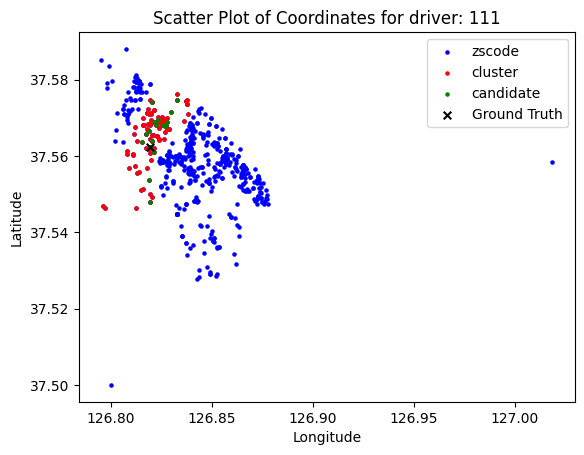

In [13]:
visulization(rate_batch, 111, test_dv, meta, 'Cluster')

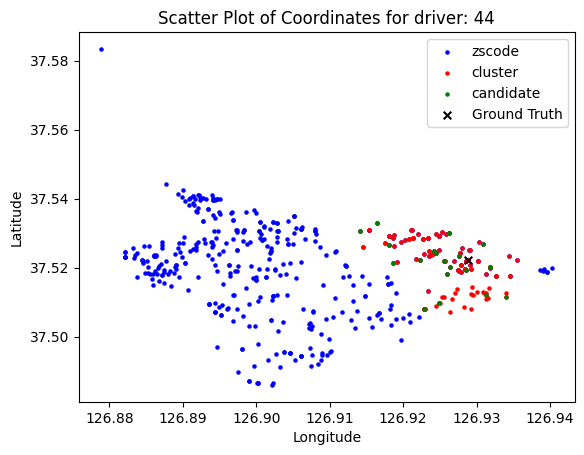

In [14]:
visulization(rate_batch, 44, test_dv, meta, 'Cluster')

In [15]:
test_dv = test_dv.sort_values(by=['Driver']).reset_index(drop=True)

In [16]:
def load_and_concatenate_batches(save_dir, n_batches):
    batches = []
    for u_batch_id in range(n_batches):
        batch_file = os.path.join(save_dir, f'batch_{u_batch_id}.npy')
        rate_batch = np.load(batch_file)
        batches.append(rate_batch)
    entire_rank = np.concatenate(batches, axis=0)
    return entire_rank

# 전체 배치 개수 계산
n_batches = 5
# save_dir = './rank_batches2'
# 저장된 배치 배열을 읽어서 결합
entire_rank = load_and_concatenate_batches(save_dir, n_batches)

In [17]:
def get_ndcg(recommended_df, test_dv, driver_id, K):
    busiid = test_dv.loc[test_dv['Driver'] == driver_id]['busiid'].values[0]
    ex = (recommended_df['busiid'] == busiid).values
    
    ndcgs = []
    for j in K:
        if len(ex) >= j:
            dcg = 0
            for i in range(j):
                if ex[i] == True:
                    dcg += 1/np.log2(2 + i)

            idcg = 0
            sum_ex = ex.sum()
            if sum_ex >= j:
                for i in range(j):
                    idcg += 1/np.log2(2 + i)
            else:
                for i in range(sum_ex):
                    idcg += 1/np.log2(2 + i)

            if idcg == 0:
                ndcgs.append(0)
            else:
                ndcgs.append(dcg/idcg)
        else:
            ndcgs.append(ndcgs[-1])

    return ndcgs

In [18]:
ndcgs = []
for i in tqdm(range(10000)):
    a, b, c = evaluation(entire_rank, i, test_dv, meta, 'zscode')
    try:
        ndcg = get_ndcg(a, test_dv, i, [1, 5, 10, 15, 20])
        ndcgs.append(ndcg)
    except:
        print(i)

100%|██████████| 10000/10000 [58:30<00:00,  2.85it/s] 


In [19]:
ndcgs = np.array(ndcgs)
np.save('./rank_batches_DGCF/ndcgs_zscode_10000.npy', ndcgs)

In [20]:
zscodendcg = np.load('./rank_batches_DGCF/ndcgs_zscode_10000.npy')
zscodendcg.mean(axis=0)

array([0.1161    , 0.1554938 , 0.23085815, 0.29806   , 0.35499284])

In [21]:
ndcgs1 = []
for i in tqdm(range(10000)):
    a, b, c = evaluation(entire_rank, i, test_dv, meta, 'Cluster')
    try:
        ndcg = get_ndcg(a, test_dv, i, [1, 5, 10, 15 ,20])
        ndcgs1.append(ndcg)
    except:
        print(i)

100%|██████████| 10000/10000 [2:04:45<00:00,  1.34it/s] 


In [22]:
ndcgs1 = np.array(ndcgs1)
np.save('./rank_batches_DGCF/ndcgs_cluster_10000.npy', ndcgs1)

In [23]:
clusterndcg = np.load('./rank_batches_DGCF/ndcgs_cluster_10000.npy')
clusterndcg.mean(axis=0)

array([0.1836    , 0.25980049, 0.34730638, 0.40408514, 0.44905553])

In [24]:
def get_recall(recommended_df, test_dv, driver_id, K):
    criteria = test_dv.loc[test_dv['Driver'] == driver_id]['statid'].values[0]
    ex = recommended_df['statid']
    
    pres_K = []
    for k in K:
        if (criteria in list(ex[:k])):
            pres_K.append(1)
        else:
            pres_K.append(0)
    return np.array(pres_K)

In [25]:
recalls = np.zeros(5)
for i in tqdm(range(10000)):
    a, b, c = evaluation(entire_rank, i, test_dv, meta, 'zscode')
    try:
        recall = get_recall(a, test_dv, i, [1, 5, 10, 15, 20])
        recalls += recall
    except:
        print(i)

100%|██████████| 10000/10000 [58:16<00:00,  2.86it/s] 


In [26]:
recalls/10000

array([0.0249, 0.086 , 0.1487, 0.2024, 0.2465])

In [27]:
recalls1 = np.zeros(5)
for i in tqdm(range(10000)):
    a, b, c = evaluation(entire_rank, i, test_dv, meta, 'Cluster')
    try:
        recall = get_recall(a, test_dv, i, [1, 5, 10, 15, 20])
        recalls1 += recall
    except:
        print(i)

100%|██████████| 10000/10000 [2:04:07<00:00,  1.34it/s] 


In [28]:
recalls1/10000

array([0.0775, 0.2899, 0.4544, 0.5554, 0.6265])

In [29]:
meta

,statnm,statid,chgerid,chgertype,addr,location,lat,lng,busiid,bnm,...,zcode,zscode,kind,kinddetail,parkingfree,note,trafficyn,speed,Count,Cluster
0,암사1동 공영주차장,0,01,6,서울특별시 강동구 고덕로28길 36,null,37.552909,127.137255,63,환경부,...,11,11740,B0,B001,N,None,N,1,1,349
1,천호유수지 공영주차장,1,01,6,서울특별시 강동구 선사로 70,null,37.544812,127.121840,63,환경부,...,11,11740,B0,B001,N,None,N,1,1,347
2,천호3동 제1공영주차장,2,01,6,서울특별시 강동구 진황도로29길 34,null,37.538795,127.133399,63,환경부,...,11,11740,B0,B001,N,None,N,1,1,347
3,가로공원로 지하공영주차장,3,01,6,서울특별시 강서구 가로공원로 189,null,37.537263,126.838379,63,환경부,...,11,11500,B0,B001,N,None,N,1,1,4
4,곰달래문화복지센터 공영주차장,4,01,6,서울특별시 강서구 강서로5길 50,null,37.528956,126.849089,63,환경부,...,11,11500,B0,B001,N,None,N,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32052,춘천우체국,30891,01,2,강원특별자치도 춘천시 방송길 108,null,37.867039,127.720537,21,이지차저,...,51,51110,A0,A003,N,관리 시설에 따른 이용 제한이 있을 수 있음,N,0,1,462
32053,시흥시청,30892,01,4,경기도 시흥시 시청로 20,지상1층 주차장,37.379704,126.801784,16,채비,...,41,41390,A0,A001,N,None,N,1,6,42
32054,군포동아아파트,30893,01,2,경기도 군포시 군포로490번길 22,지상1층 주차장,37.350012,126.946231,16,채비,...,41,41410,H0,H001,Y,None,N,0,7,66
32055,반월호수주차타워,30894,01,6,경기도 군포시 호수로 97,실내주차장,37.325129,126.890020,16,채비,...,41,41410,B0,B001,N,None,N,1,2,62


In [32]:
test_dv.columns

Index(['statid', 'Driver', 'statnm', 'chgerid', 'chgertype', 'addr',
       'location', 'lat', 'lng', 'busiid', 'bnm', 'businm', 'busicall',
       'powertype', 'output', 'method', 'zcode', 'zscode', 'kind',
       'kinddetail', 'parkingfree', 'note', 'trafficyn', 'speed', 'Count',
       'Cluster'],
      dtype='object')

In [31]:
train_dv

,Driver,statid,speed,statnm,chgerid,chgertype,addr,location,lat,lng,...,method,zcode,zscode,kind,kinddetail,parkingfree,note,trafficyn,Count,Cluster
0,0,13866,0,힐마루골프엔리조트 직원기숙사,01,2,경기도 포천시 영중면 금화봉4길 77,null,37.989111,127.223991,...,단독,41,41650,E0,E004,N,None,N,3,283
1,0,18993,0,삼환아파트,00,2,서울특별시 영등포구 여의대방로43나길 25,null,37.506624,126.920789,...,단독,11,11560,H0,H001,N,None,N,21,21
2,0,19451,0,캐슬앤파밀리에시티1단지,00,2,경기도 김포시 고촌읍 태리로 236,null,37.595036,126.755048,...,단독,41,41570,H0,H001,N,None,N,100,119
3,1,26639,0,분당테크노파크e동,01,2,경기도 성남시 분당구 판교로 700,E동옆 지상1층_주차장,37.404215,127.151696,...,단독,41,41130,G0,G004,N,None,N,6,323
4,1,14300,0,양주 제네시스,01,2,경기도 양주시 고삼로 109,null,37.797812,127.095626,...,단독,41,41630,E0,E004,N,None,N,2,299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667205,185334,11399,0,고덕자이아파트,09,2,서울특별시 강동구 상일로 55,null,37.552427,127.170528,...,단독,11,11740,H0,H001,Y,None,N,83,348
667206,185335,1902,1,도로교통공단 강서운전면허시험장 별관 제1주차장,01,4,서울특별시 강서구 남부순환로 171,지상1층 입구 우측 4시 방향 52m지점,37.549159,126.820214,...,동시,11,11500,A0,A003,Y,None,N,2,3
667207,185335,1413,1,에버랜드 셔틀버스 승강장,01,6,경기도 용인시 처인구 포곡읍 곡현로 76,null,37.288590,127.216361,...,단독,41,41460,E0,E003,Y,None,N,8,203
667208,185335,15731,0,동두천시 송내4공영주차장,01,2,경기도 동두천시 중앙로 110-18,지상주차장,37.890883,127.053231,...,단독,41,41250,B0,B001,Y,None,N,1,288


In [34]:
test_dv.loc[test_dv['Driver'] == 44]['zscode'].values[0]

'11560'

In [35]:
test_dv.loc[test_dv['Driver'] == 44]['statid'].values[0]

'12085'

In [38]:
entire_rank[44].argsort()[::-1].astype(str)

array(['20259', '26273', '119', ..., '4882', '24874', '24139'],
      dtype='<U21')

In [40]:
meta[meta['zscode'] == '11560']

,statnm,statid,chgerid,chgertype,addr,location,lat,lng,busiid,bnm,...,zcode,zscode,kind,kinddetail,parkingfree,note,trafficyn,speed,Count,Cluster
24,신길6동 공영노외주차장(구 신길 제5동 주민센터),24,01,6,서울특별시 영등포구 신길동 3203,null,37.502513,126.911050,63,환경부,...,11,11560,G0,G003,N,None,N,1,1,21
25,신길4동1마을공원 공영주차장,25,01,6,서울특별시 영등포구 신길로40길 5,null,37.507122,126.911682,63,환경부,...,11,11560,B0,B001,N,None,N,1,1,21
26,영등포 제3공영,26,01,6,서울특별시 영등포구 영중로3길 7,null,37.518009,126.903087,63,환경부,...,11,11560,B0,B001,N,None,N,1,1,9
146,국회도서관,146,01,6,"서울특별시 영등포구 의사당대로1, 국회도서관 앞",null,37.530000,126.916999,63,환경부,...,11,11560,A0,A003,Y,None,N,1,3,24
158,국회의원회관,158,01,6,"서울특별시 영등포구 의사당대로1, 국회의원회관 주차장 우측",null,37.528464,126.914920,63,환경부,...,11,11560,A0,A003,Y,None,N,1,3,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32003,서울영등포 코오롱스타폴리스,30842,01,2,서울특별시 영등포구 영신로 219,지하3층 물탱크실 앞 5기,37.527387,126.902878,29,에버온,...,11,11560,H0,H001,Y,None,N,0,5,9
32015,당산 SH-VILLE_서울시,30854,01,2,서울특별시 영등포구 영신로 183,null,37.524106,126.901859,21,이지차저,...,11,11560,H0,H001,Y,관리 시설에 따른 이용 제한이 있을 수 있음,N,0,3,9
32016,신길삼성아파트_서울시,30855,01,2,서울특별시 영등포구 신길로42길 25,null,37.507319,126.913735,21,이지차저,...,11,11560,H0,H001,Y,관리 시설에 따른 이용 제한이 있을 수 있음,N,0,2,21
32026,서울 영등포 리버뷰신안인스빌2단지아파트 B1F,30865,01,2,서울특별시 영등포구 도림로143길 27,2단지 지하1층 주차장 17번 기둥옆 3대,37.513585,126.890658,41,한화솔루션,...,11,11560,H0,H001,N,None,N,0,3,9
